#### Introduction: This project focuses on predicting insurance prices using various tree-based regression models, including Linear Regression, Random Forest, XGBoost, and Gradient Boosting. We also performed hyperparameter optimization to improve model performance.

In [1]:
# !pip install seaborn
# !pip install xgboost

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_squared_log_error
from sklearn.manifold import TSNE
from math import sqrt
from scipy.stats import probplot

In [3]:
# Load
df = pd.read_csv("./insurance.csv")
print(df.shape)
df.head()

(1338, 7)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
# check missing value.
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [5]:
# check duplicated rows.
duplicate_rows_data = df[df.duplicated()]
print("number of duplicate rows: ", duplicate_rows_data.shape)

number of duplicate rows:  (1, 7)


In [6]:
df = df.drop_duplicates()

In [7]:
df.describe()

,age,bmi,children,charges
count,1337.000000,1337.000000,1337.000000,1337.000000
mean,39.222139,30.663452,1.095737,13279.121487
std,14.044333,6.100468,1.205571,12110.359656
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.290000,0.000000,4746.344000
50%,39.000000,30.400000,1.000000,9386.161300
75%,51.000000,34.700000,2.000000,16657.717450
max,64.000000,53.130000,5.000000,63770.428010


In [8]:
df.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [9]:
for column in df.columns[df.dtypes == 'object']:
    num_distinct_values = len(df[column].unique())
    print(f"{column}: {num_distinct_values}")

sex: 2
smoker: 2
region: 4


In [10]:
df[['smoker']].value_counts()

smoker
no        1063
yes        274
Name: count, dtype: int64

In [11]:
df[['region']].value_counts()

region   
southeast    364
southwest    325
northeast    324
northwest    324
Name: count, dtype: int64

In [12]:
df['children'].value_counts()

children
0    573
1    324
2    240
3    157
4     25
5     18
Name: count, dtype: int64

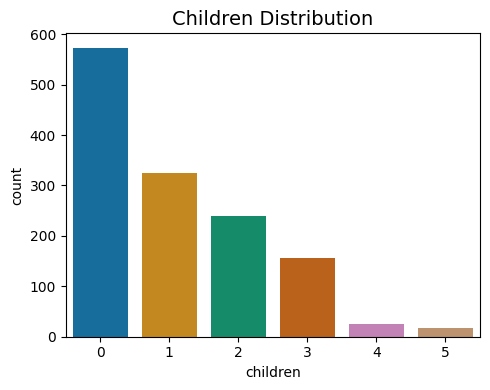

In [13]:
plt.figure(figsize=(5, 4))
sns.countplot(x='children', data=df, palette='colorblind')
plt.title('Children Distribution', fontsize=14)
plt.tight_layout()
plt.show()

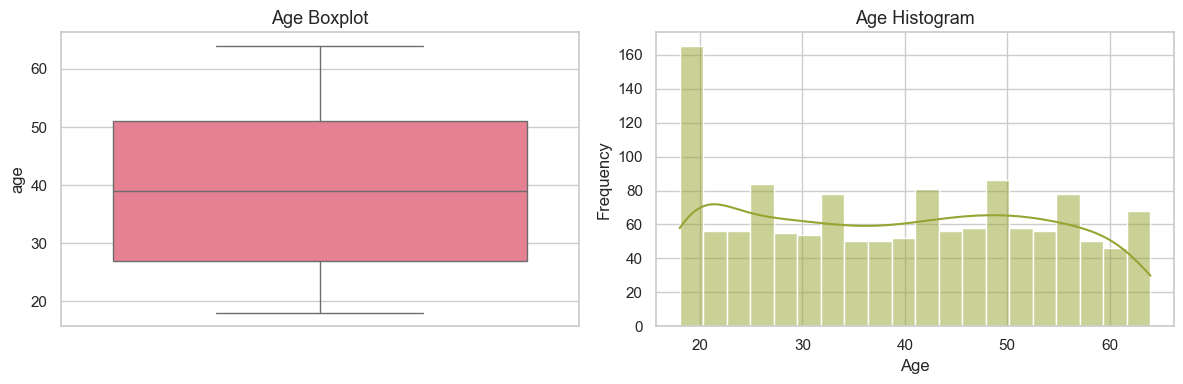

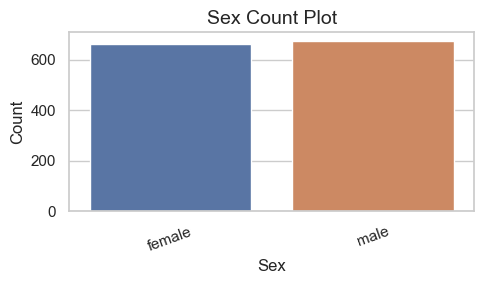

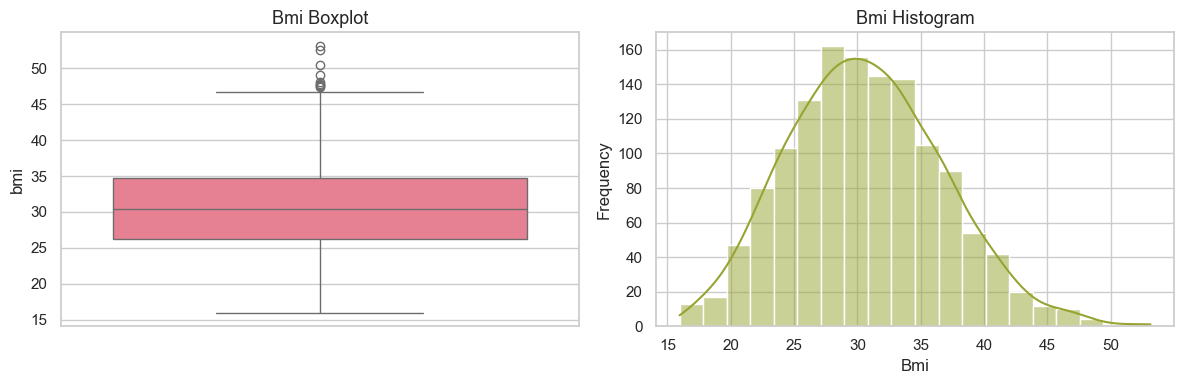

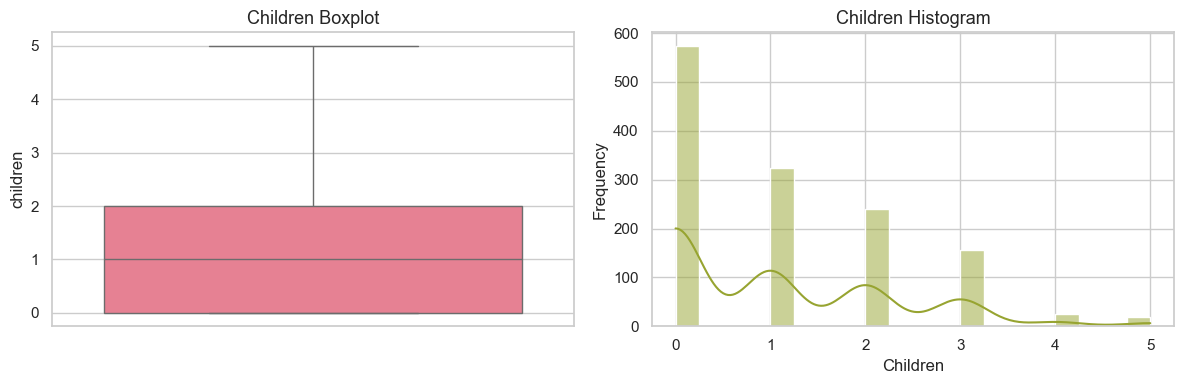

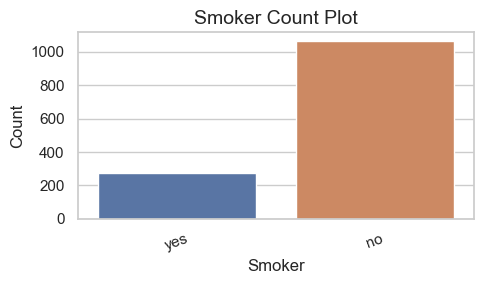

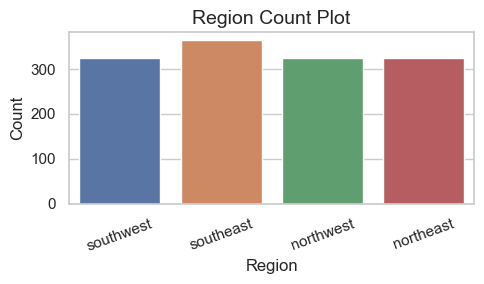

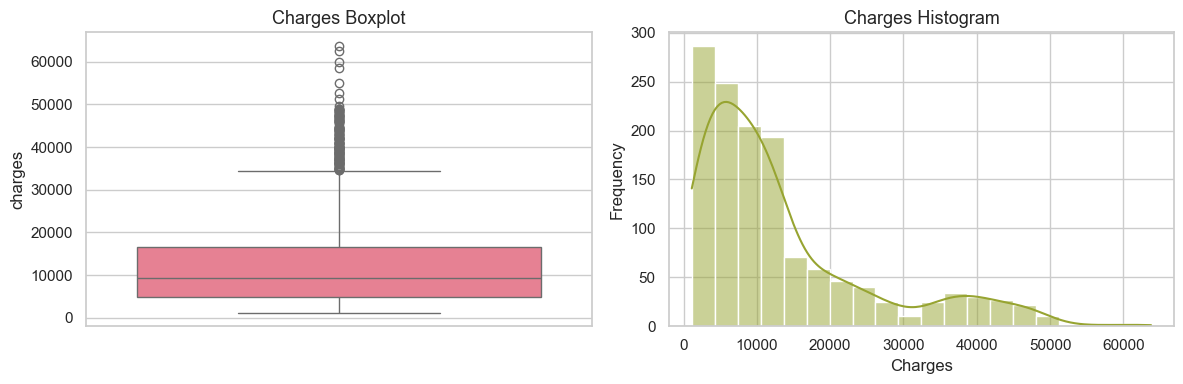

In [14]:

sns.set(style='whitegrid', palette='Set2')

# Loop through all columns
for col in df.columns:
    # Categorical variables
    if df[col].dtype in ['object', 'category']:
        plt.figure(figsize=(5, 3))
        sns.countplot(x=col, data=df, palette='deep')
        plt.title(f'{col.capitalize()} Count Plot', fontsize=14)
        plt.xlabel(col.capitalize())
        plt.ylabel('Count')
        plt.xticks(rotation=20)
        plt.tight_layout()
        plt.show()

    else:
        # Numerical variables: boxplot + histogram side-by-side
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        
        # Boxplot
        sns.boxplot(y=df[col], ax=axes[0], color=sns.color_palette("husl", 8)[0])
        axes[0].set_title(f'{col.capitalize()} Boxplot', fontsize=13)

        # Histogram with KDE
        sns.histplot(df[col], bins=20, kde=True, ax=axes[1], color=sns.color_palette("husl", 8)[2])
        axes[1].set_title(f'{col.capitalize()} Histogram', fontsize=13)
        axes[1].set_xlabel(col.capitalize())
        axes[1].set_ylabel('Frequency')

        plt.tight_layout()
        plt.show()

<Figure size 400x400 with 0 Axes>

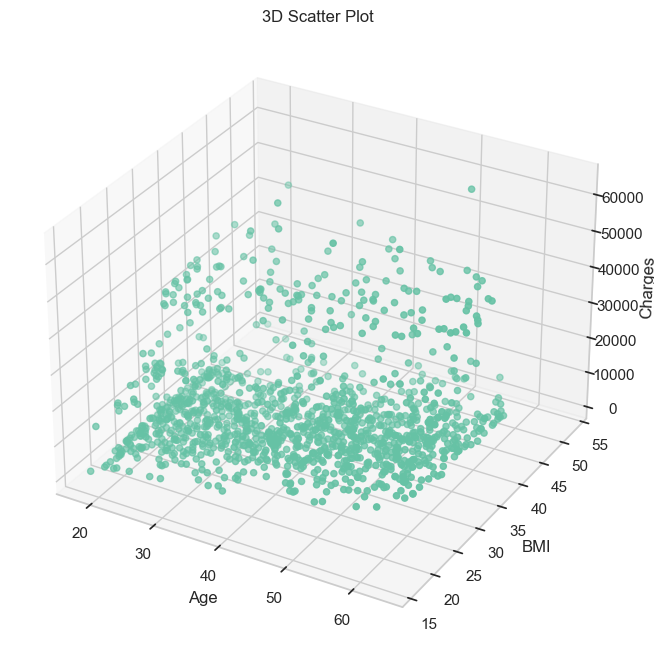

In [15]:
#  3D scatter plot
from mpl_toolkits.mplot3d import Axes3D
plt.figure(figsize=(4, 4))
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['age'], df['bmi'], df['charges'])
ax.set_xlabel('Age')
ax.set_ylabel('BMI')
ax.set_zlabel('Charges')
plt.title('3D Scatter Plot')
plt.show()

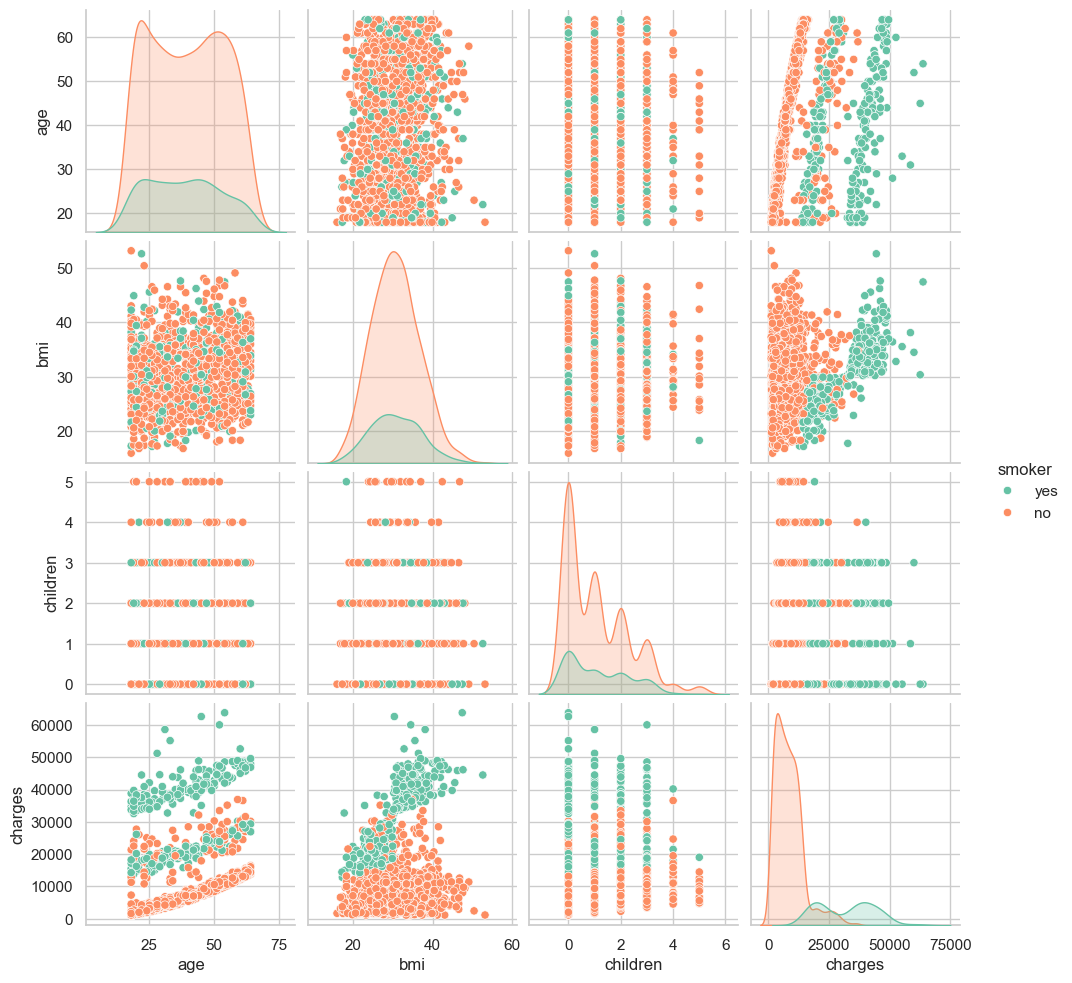

In [16]:
# Pair plot
sns.pairplot(df, hue='smoker')
plt.show()

### K-Cluster

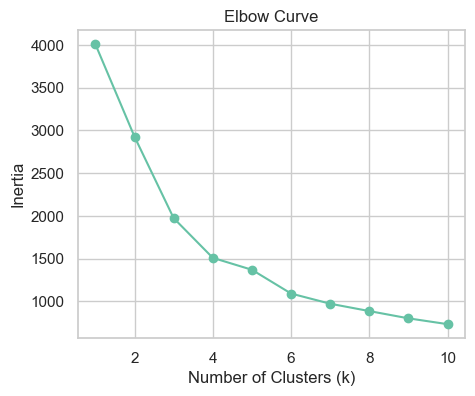

In [17]:
# Select features 
features = ['age', 'bmi', 'charges']
categorical_features = ['sex', 'smoker']

# One-hot encoding
df_encoded = pd.get_dummies(df, columns=categorical_features, drop_first=True)
X = df_encoded[features]

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Elbow method: determine the optimal number of clusters
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot curve
plt.figure(figsize=(5, 4))
plt.plot(range(1, 11), inertia, marker='o', linestyle='-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Curve')
plt.show()

               age        bmi       charges
cluster                                    
0        39.945455  35.363394  40278.617496
1        26.337423  27.609070   6239.814936
2        43.948276  37.722586   8747.404416
3        51.463104  27.281654  14046.302179


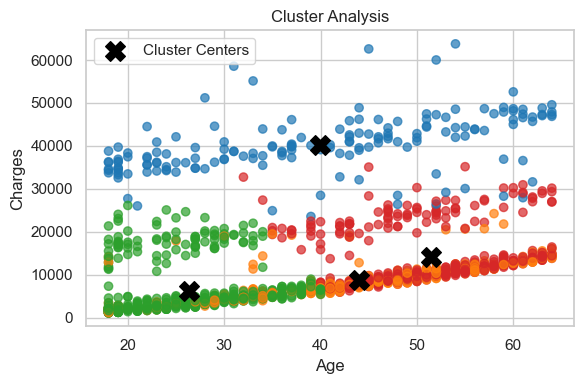

In [18]:
# Choose k = 4
k = 4

# k-means clustering
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X_scaled)
labels = kmeans.labels_

df['cluster'] = labels
cluster_analysis = df.groupby('cluster')[features].mean()
print(cluster_analysis)

# Visualization
plt.figure(figsize=(6, 4))
colors = ['#1f77b4', '#2ca02c', '#ff7f0e', '#d62728']  # Custom color list (blue, green, orange, red)
plt.scatter(df['age'], df['charges'], c=df['cluster'].map(lambda x: colors[x]), alpha=0.7)

# Cluster centers
plt.scatter(cluster_analysis['age'], cluster_analysis['charges'], 
            c='black', marker='X', s=200, label='Cluster Centers')

plt.xlabel('Age')
plt.ylabel('Charges')
plt.title('Cluster Analysis')
plt.legend()
plt.tight_layout()
plt.show()

##### t-SNE

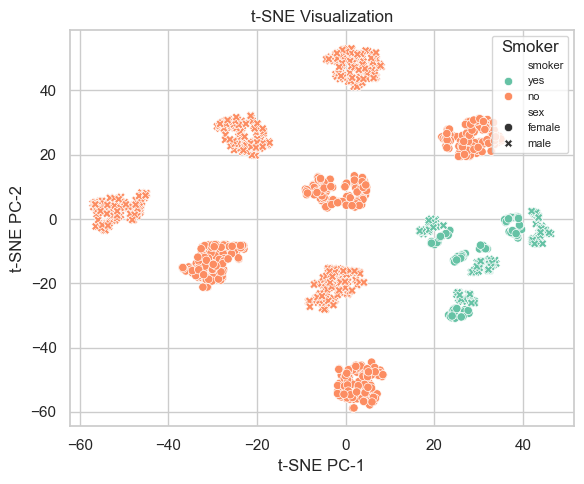

In [19]:
#Select features
numerical_features = ['age', 'bmi', 'charges']
categorical_features = ['sex', 'smoker', 'region']

# Encode 
df_encoded = pd.get_dummies(df, columns=categorical_features, drop_first=True)

# Standardize 
scaler = StandardScaler()
X = scaler.fit_transform(df_encoded[numerical_features + list(df_encoded.columns[df_encoded.columns.str.startswith(tuple(categorical_features))])])

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

# Create a scatter plot of t-SNE results with color-coding
plt.figure(figsize=(6, 5))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=df['smoker'], style=df['sex'])
plt.xlabel('t-SNE PC-1')
plt.ylabel('t-SNE PC-2')
plt.title('t-SNE Visualization')
plt.legend(title='Smoker', loc='upper right', fontsize=8)
plt.tight_layout()
plt.show()

### Tree-based models

In [ ]:
# Step 1: Split the data
X = df.drop('charges', axis = 1)
y = df['charges']
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.3, random_state=101)

In [21]:
# Step 2: One-hot encode categorical variables
X_train_encoded = pd.get_dummies(X_train, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, drop_first=True)

# Step 3: Align columns (ensure test set has same dummy columns)
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

# Step 4: Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

#### Linear Regression Model

In [22]:
# Linear Regression Model
linear_reg_model= LinearRegression()
linear_reg_model.fit(X_train_scaled, y_train)

y_pred = linear_reg_model.predict(X_test_scaled)
y_pred = pd.DataFrame(y_pred)
MAE_li_reg= metrics.mean_absolute_error(y_test, y_pred)
MSE_li_reg = metrics.mean_squared_error(y_test, y_pred)
RMSE_li_reg =np.sqrt(MSE_li_reg)
pd.DataFrame([MAE_li_reg, MSE_li_reg, RMSE_li_reg], index=['MAE_li_reg', 'MSE_li_reg', 'RMSE_li_reg'], columns=['Metrics'])

,Metrics
MAE_li_reg,3.752862e+03
MSE_li_reg,2.876127e+07
RMSE_li_reg,5.362954e+03


In [23]:
scores = cross_val_score(linear_reg_model, X_train_scaled, y_train, cv=5)
r2_val = r2_score(y_test, linear_reg_model.predict(X_test_scaled))
print(np.sqrt(scores))
print(r2_val)

[0.91125852 0.89294293 0.89467948 0.8963249  0.90587099]
0.7947626109714043


In [24]:
# Decision Tree Regressor Model
tree_reg_model =DecisionTreeRegressor()
tree_reg_model.fit(X_train_scaled, y_train)

y_pred = tree_reg_model.predict(X_test_scaled)
y_pred = pd.DataFrame(y_pred)
MAE_tree_reg= metrics.mean_absolute_error(y_test, y_pred)
MSE_tree_reg = metrics.mean_squared_error(y_test, y_pred)
RMSE_tree_reg =np.sqrt(MSE_tree_reg)
pd.DataFrame([MAE_tree_reg, MSE_tree_reg, RMSE_tree_reg], index=['MAE_tree_reg', 'MSE_tree_reg', 'RMSE_tree_reg'], columns=['Metrics'])



,Metrics
MAE_tree_reg,2.583498e+03
MSE_tree_reg,3.259073e+07
RMSE_tree_reg,5.708829e+03


In [25]:
scores = cross_val_score(tree_reg_model, X_train_scaled, y_train, cv=5)
r2_val = r2_score(y_test, tree_reg_model.predict(X_test_scaled))
print(np.sqrt(scores))
print(r2_val)

[0.91305054 0.88912307 0.87512257 0.89345751 0.87709087]
0.767435988660198


#### Random Forest Regressor Model

In [26]:
# Random Forest Regressor Model
forest_reg_model =RandomForestRegressor()
forest_reg_model.fit(X_train_scaled, y_train)

y_pred = forest_reg_model.predict(X_test_scaled)
y_pred = pd.DataFrame(y_pred)
MAE_forest_reg= metrics.mean_absolute_error(y_test, y_pred)
MSE_forest_reg = metrics.mean_squared_error(y_test, y_pred)
RMSE_forest_reg =np.sqrt(MSE_forest_reg)
pd.DataFrame([MAE_forest_reg, MSE_forest_reg, RMSE_forest_reg], index=['MAE_forest_reg', 'MSE_forest_reg', 'RMSE_forest_reg'], columns=['Metrics'])


,Metrics
MAE_forest_reg,2.241512e+03
MSE_forest_reg,1.859238e+07
RMSE_forest_reg,4.311888e+03


In [27]:
scores = cross_val_score(forest_reg_model, X_train_scaled, y_train, cv=5)
r2_val = r2_score(y_test, forest_reg_model.predict(X_test_scaled))
print(np.sqrt(scores))
print(r2_val)

[0.95291065 0.93633333 0.94070017 0.94551303 0.9343732 ]
0.867326760181508


#### XGB Regressor Model

In [28]:
# XGB Regressor Model
XGB_model =XGBRegressor()
XGB_model.fit(X_train_scaled, y_train)

y_pred = XGB_model.predict(X_test_scaled)
y_pred = pd.DataFrame(y_pred)
MAE_XGB= metrics.mean_absolute_error(y_test, y_pred)
MSE_XGB = metrics.mean_squared_error(y_test, y_pred)
RMSE_XGB =np.sqrt(MSE_XGB)
pd.DataFrame([MAE_XGB, MSE_XGB, RMSE_XGB], index=['MAE_XGB', 'MSE_XGB', 'RMSE_XGB'], columns=['Metrics'])

,Metrics
MAE_XGB,2.447881e+03
MSE_XGB,2.098250e+07
RMSE_XGB,4.580665e+03


In [29]:
scores = cross_val_score(XGB_model, X_train_scaled, y_train, cv=5)
r2_val = r2_score(y_test, XGB_model.predict(X_test_scaled))
print(np.sqrt(scores))
print(r2_val)

[0.93415796 0.92924645 0.93006375 0.92817878 0.9262221 ]
0.8502711355391979


#### Gradient Boosting Regressor Model

In [30]:
# Gradient Boosting Regressor Model
Gradient_model = GradientBoostingRegressor()
Gradient_model.fit(X_train_scaled, y_train)

y_pred = Gradient_model.predict(X_test_scaled)
y_pred = pd.DataFrame(y_pred)
MAE_gradient= metrics.mean_absolute_error(y_test, y_pred)
MSE_gradient = metrics.mean_squared_error(y_test, y_pred)
RMSE_gradient =np.sqrt(MSE_gradient)
pd.DataFrame([MAE_gradient, MSE_gradient, RMSE_gradient], index=['MAE_gradient', 'MSE_gradient', 'RMSE_gradient'], columns=['Metrics'])

,Metrics
MAE_gradient,2.147415e+03
MSE_gradient,1.729193e+07
RMSE_gradient,4.158356e+03


In [31]:
scores = cross_val_score(Gradient_model, X_train_scaled, y_train, cv=5)
r2_val = r2_score(y_test, Gradient_model.predict(X_test_scaled))
print(np.sqrt(scores))
print(r2_val)


[0.95380099 0.94370012 0.94130918 0.95180684 0.94591552]
0.8766066533054435


##### Hyperparameter Optimization

In [32]:
## Hyperparameter optimization (grid search method) 

param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.001, 0.01, 0.1, 1],
    'max_depth': [2, 3, 4, 5]
}

grid_search = GridSearchCV(estimator=Gradient_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train)

# Best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100}


In [33]:
new_Gradient_model = grid_search.best_estimator_

y_pred = Gradient_model.predict(X_test_scaled)
y_pred = pd.DataFrame(y_pred)
MAE_gradient= metrics.mean_absolute_error(y_test, y_pred)
MSE_gradient = metrics.mean_squared_error(y_test, y_pred)
RMSE_gradient =np.sqrt(MSE_gradient)
pd.DataFrame([MAE_gradient, MSE_gradient, RMSE_gradient], index=['MAE_gradient', 'MSE_gradient', 'RMSE_gradient'], columns=['Metrics'])

,Metrics
MAE_gradient,2.147415e+03
MSE_gradient,1.729193e+07
RMSE_gradient,4.158356e+03


In [34]:
scores = cross_val_score(new_Gradient_model, X_train_scaled, y_train, cv=5)
r2_val = r2_score(y_test, new_Gradient_model.predict(X_test_scaled))
print(np.sqrt(scores))
print(r2_val)

[0.95750921 0.94446374 0.94549238 0.95481248 0.94729084]
0.8818150338513995


#### Feature importance

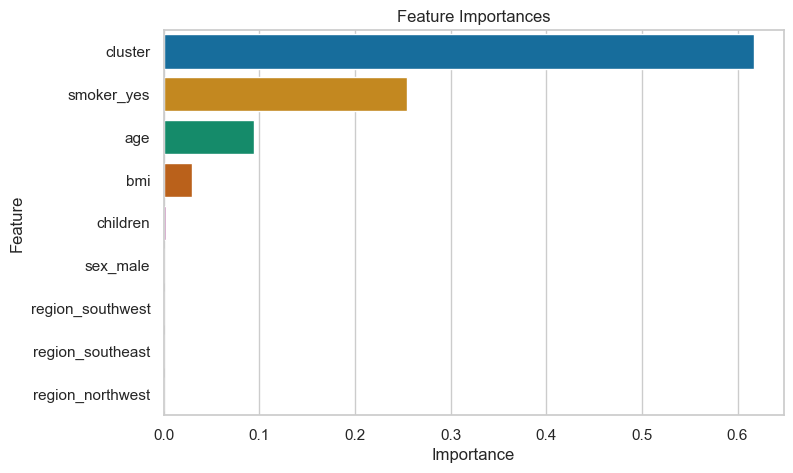

In [35]:
## Feature importance
importances = new_Gradient_model.feature_importances_

# Create a dataframe
feature_importances = pd.DataFrame({'Feature': X_train_encoded.columns, 'Importance': importances})

# Sort by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Visualize feature importances
plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='colorblind')
plt.title('Feature Importances')
plt.show()

#### Summary: After conducting exploratory data analysis, we implemented multiple tree-based models to predict healthcare insurance costs and found that the Gradient Boosting Regressor performed best. We then optimized model hyperparameters and identified the key predictive features.